sparseml.yolov5.train \
  --data faces_data.yaml \
  --cfg models_v5.0/yolov5s.yaml \
  --weights zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned_quant-aggressive_94?recipe_type=transfer \
  --hyp data/hyps/hyp.finetune.yaml \
  --recipe zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned_quant-aggressive_94?recipe_type=transfer_learn \
  --project neural_magic --name yolov5s_pruned_quant-aggressive_94

In [1]:
from deepsparse.cpu import cpu_vnni_compatible
print(f"VNNI available: {cpu_vnni_compatible()}")

VNNI available: True


In [12]:
import PIL
import numpy as np
import cv2

def draw_bbox(img, xyxy):
    draw = PIL.ImageDraw.Draw(img)

    w, h = img.size
    scale_y = h / 640.
    scale_x = w / 640.

    left = int(xyxy[0] * scale_x)
    top = int(xyxy[1] * scale_y)
    right = int(xyxy[2] * scale_x)
    bottom = int(xyxy[3] * scale_y)

    # bbox thickness of bboxes without corners
    min_bbox = 1
    max_bbox = 8
    bbox_thickness = int(0.0041 * h - 0.0058)
    if bbox_thickness < min_bbox:
        bbox_thickness = min_bbox
    if bbox_thickness > max_bbox:
        bbox_thickness = int(max_bbox)

    draw.rectangle((left, top, right, bottom), fill=None, outline="greenyellow", width=bbox_thickness)
    return img

def load_image(img, image_size = (640, 640)):
    img = cv2.imread(img) if isinstance(img, str) else img
    img_resized = cv2.resize(img, image_size)
    img_transposed = img_resized[:, :, ::-1].transpose(2, 0, 1)

    return img_transposed

(4608, 3456, 3)
(640, 640, 3)


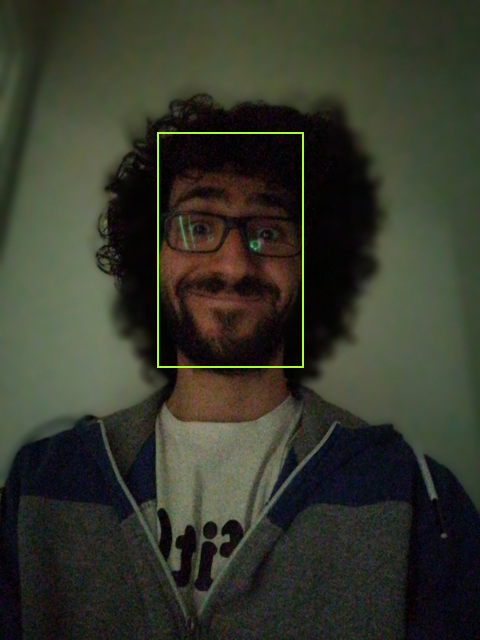

In [14]:
from deepsparse.pipeline import Pipeline

model_stub = "./neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx"
images_paths = ['./testfaces/fraface7.jpeg']
images = [load_image(i) for i in images_paths]

yolo_pipeline = Pipeline.create(
    task="yolo",
    model_path=model_stub,
)

pipeline_outputs = yolo_pipeline(images=images, iou_thres=0.6, conf_thres=0.5)

boxes = pipeline_outputs[0].boxes
scores = pipeline_outputs[0].scores

img = PIL.Image.open(images_paths[0])
img.thumbnail((640, 640))
img = draw_bbox(img, boxes[0])
img

In [9]:
# img = PIL.Image.open(images[0])
# img.thumbnail((640, 640))

# w, h = img.size
# scale_y = h / 640.
# scale_x = w / 640.

# left = boxes[0][0] * scale_x
# top = boxes[0][1] * scale_y
# right = boxes[0][2] * scale_x
# bottom = boxes[0][3] * scale_y

# xyxy = (left, top, right, bottom)

# img = draw_bbox(img, xyxy)
# img

In [13]:
!sparseml.yolov5.export_onnx --weights ~/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.pt  --dynamic

wandb: Currently logged in as: frapochetti. Use `wandb login --relogin` to force relogin
export: data=../../anaconda3/envs/nm/lib/python3.9/site-packages/sparseml/yolov5/data/coco128.yaml, weights=['/home/ubuntu/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=True, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, remove_grid=False, include=['torchscript', 'onnx']
export: data=../../anaconda3/envs/nm/lib/python3.9/site-packages/sparseml/yolov5/data/coco128.yaml, weights=['/home/ubuntu/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=True, simp

In [2]:
!deepsparse.object_detection.annotate --source ./testfaces/fraface7.jpeg --model_filepath ~/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx

2022-07-16 15:12:15 deepsparse.utils.annotate INFO     Results will be saved to annotation-results/deepsparse-annotations/deepsparse-annotations-004
DeepSparse Engine, Copyright 2021-present / Neuralmagic, Inc. version: 1.1.0.20220716 (6f6a28ba) (release) (optimized) (system=avx512_vnni, binary=avx512)
(4608, 3456, 3)
(640, 640, 3)
(4608, 3456, 3) (640, 640)
2022-07-16 15:12:24 deepsparse.yolo.annotate INFO     Results saved to annotation-results/deepsparse-annotations/deepsparse-annotations-004


In [23]:
!deepsparse.benchmark ~/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx --scenario async

2022-07-12 22:32:26 deepsparse.benchmark.benchmark_model INFO     Thread pinning to cores enabled
DeepSparse Engine, Copyright 2021-present / Neuralmagic, Inc. version: 1.0.1 (2b0116b5) (release) (optimized) (system=avx512, binary=avx512)
2022-07-12 22:32:35 deepsparse.benchmark.benchmark_model INFO     num_streams default value chosen of 1. This requires tuning and may be sub-optimal
2022-07-12 22:32:35 deepsparse.benchmark.benchmark_model INFO     deepsparse.engine.Engine:
	onnx_file_path: /home/ubuntu/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx
	batch_size: 1
	num_cores: 2
	num_streams: 0
	scheduler: Scheduler.multi_stream
	cpu_avx_type: avx512
	cpu_vnni: True
2022-07-12 22:32:35 deepsparse.utils.onnx INFO     Generating input 'input', type = uint8, shape = [1, 3, 640, 640]
2022-07-12 22:32:35 deepsparse.benchmark.benchmark_model INFO     Starting 'multistream' performance measurements for 10 seconds
Original Model Path: /hom

In [ ]:
!deepsparse.server --task yolo --model_path ~/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx

In [1]:
import requests
import json

url = 'http://0.0.0.0:5543/predict/from_files'
path = ['./testfaces/fraface7.jpeg'] # list of images for inference
files = [('request', open(img, 'rb')) for img in path]
resp = requests.post(url=url, files=files)
# annotations = json.loads(resp.text) # dictionary of annotation results
# bounding_boxes = annotations["predictions"]
# labels = annotations["labels"]